# Julia: First Steps

This is just a copy of the Python demo.

In [1]:
import Optim
import PyPlot
import celerite

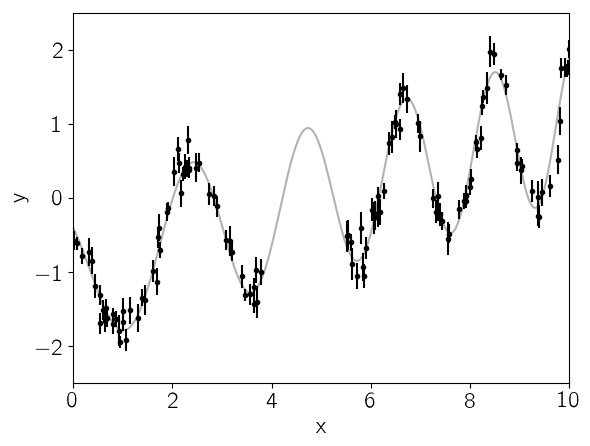

In [2]:
srand(42)

# The input coordinates must be sorted
t = sort(cat(1, 3.8 * rand(57), 5.5 + 4.5 * rand(68)))
yerr = 0.08 + (0.22-0.08)*rand(length(t))
y = 0.2*(t-5.0) + sin(3.0*t + 0.1*(t-5.0).^2) + yerr .* randn(length(t))

true_t = linspace(0, 10, 5000)
true_y = 0.2*(true_t-5) + sin(3*true_t + 0.1*(true_t-5).^2)

PyPlot.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
PyPlot.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.xlim(0, 10)
PyPlot.ylim(-2.5, 2.5);

In [3]:
Q = 1.0 / sqrt(2.0)
w0 = 3.0
S0 = var(y) / (w0 * Q)
kernel = celerite.SHOTerm(log(S0), log(Q), log(w0))

# A periodic component
Q = 1.0
w0 = 3.0
S0 = var(y) / (w0 * Q)
kernel = kernel + celerite.SHOTerm(log(S0), log(Q), log(w0))

celerite.TermSum((celerite.SHOTerm(-0.7432145976901582,-0.34657359027997275,1.0986122886681096),celerite.SHOTerm(-1.089788187970131,0.0,1.0986122886681096)))

In [4]:
gp = celerite.Celerite(kernel)
celerite.compute(gp, t, yerr)
celerite.log_likelihood(gp, y)

-15.225587873319103

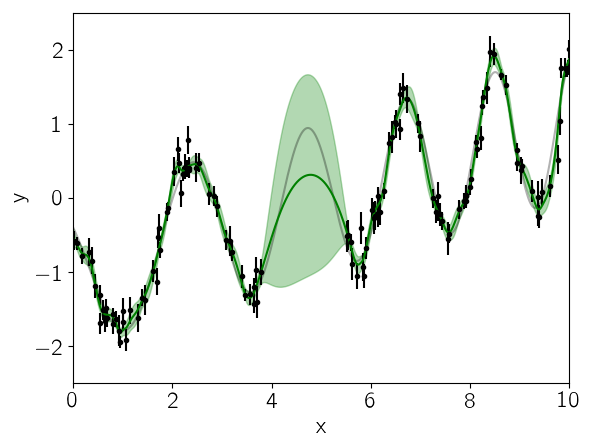

In [5]:
mu, variance = celerite.predict(gp, y, true_t, return_var=true)
sigma = sqrt(variance)

PyPlot.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
PyPlot.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
PyPlot.plot(true_t, mu, "g")
PyPlot.fill_between(true_t, mu+sigma, mu-sigma, color="g", alpha=0.3)
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.xlim(0, 10)
PyPlot.ylim(-2.5, 2.5);

In [6]:
vector = celerite.get_parameter_vector(gp.kernel)
mask = ones(Bool, length(vector))
mask[2] = false  # Don't fit for the first Q
function nll(params)
    vector[mask] = params
    celerite.set_parameter_vector(gp.kernel, vector)
    celerite.compute(gp, t, yerr)
    return -celerite.log_likelihood(gp, y)
end

nll (generic function with 1 method)

In [7]:
result = Optim.optimize(nll, vector[mask], Optim.LBFGS())
result

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-0.7432145976901582,1.0986122886681096, ...]
 * Minimizer: [3.0068763552021567,-2.005554052352084, ...]
 * Minimum: -3.042655e+00
 * Iterations: 21
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 86
 * Gradient Calls: 86

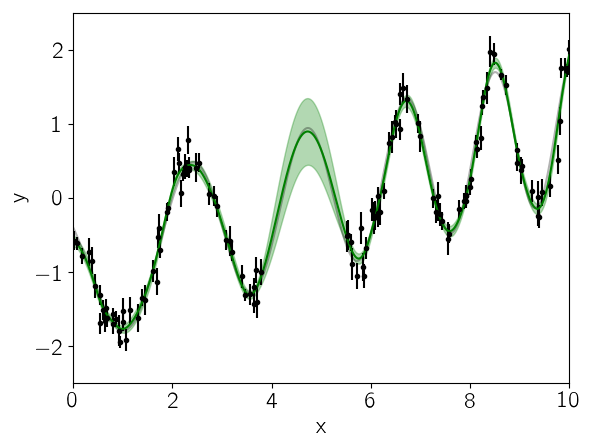

In [8]:
vector[mask] = Optim.minimizer(result)
celerite.set_parameter_vector(gp.kernel, vector)

mu, variance = celerite.predict(gp, y, true_t, return_var=true)
sigma = sqrt(variance)

PyPlot.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
PyPlot.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
PyPlot.plot(true_t, mu, "g")
PyPlot.fill_between(true_t, mu+sigma, mu-sigma, color="g", alpha=0.3)
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.xlim(0, 10)
PyPlot.ylim(-2.5, 2.5);

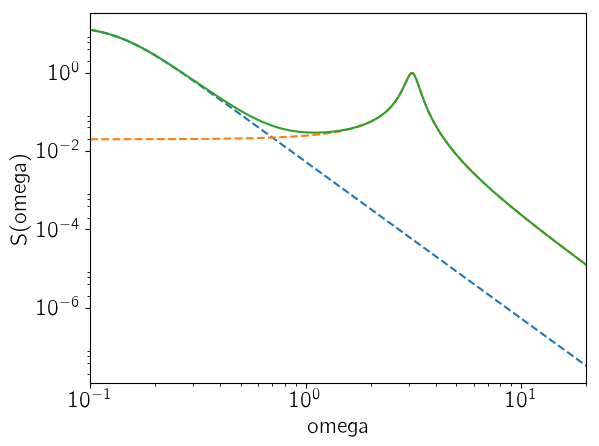

In [12]:
omega = exp(linspace(log(0.1), log(20), 5000))
psd = celerite.get_psd(gp.kernel, omega)

for term in gp.kernel.terms
    PyPlot.plot(omega, celerite.get_psd(term, omega), "--")
end
PyPlot.plot(omega, psd)

PyPlot.yscale("log")
PyPlot.xscale("log")
PyPlot.xlim(omega[1], omega[end])
PyPlot.xlabel("omega")
PyPlot.ylabel("S(omega)");